Analysis of whether gem value (the stored fitness boost) corresponds to actual fitness boost after application.

In [1]:
import os
import pickle
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pycgp import probabilistic_mutation, point_mutation, single_mutation
from pycgp.gems import MatchByActiveStrategy, MatchSMStrategy, MatchPMStrategy

In [16]:
class DataIterator():
    def __init__(self, folder):
        self.mutations = [
          #  (probabilistic_mutation, MatchSMStrategy),
            (point_mutation, MatchPMStrategy),
            (single_mutation, MatchSMStrategy),
            (single_mutation, MatchByActiveStrategy),
            (probabilistic_mutation, MatchByActiveStrategy)
        ]
        self.gems = [5, 10]
        
        self.cols = [10, 50, 100]
        
        data = []
        for m,s,g,c,dd in self.__iterate_folder(folder):
            data.append([m, s, g, c, [x['ga_values'] for x in dd]])
        data = pd.DataFrame(data)
        data.columns = ['m', 's', 'g', 'c', 'gem_data']
        self.data = data      
    
    def __iterate_folder(self,folder):
        for index, ((mutation, strategy), gem, column) in enumerate(product(self.mutations, self.gems, self.cols)):
            file = os.path.join(folder,  f'{mutation.__name__}-{strategy.__name__}-gems{gem}-n_cols{column}.csv')
            with open (file, 'rb') as fp:
                data = pickle.load(fp)

                yield mutation.__name__, strategy.__name__, gem, column, data
    
    def iterate_gem_data(self, mutation, strategy, axis=False):
        gdatas = self.data[(self.data.m == mutation) & (self.data.s == strategy) & (self.data.g != 0)]

        if axis:
            _, axs = plt.subplots(2, len(gdatas)//2, figsize=(8,6))

        for i, (_, gdata) in enumerate(gdatas.iterrows()):
            pgdata = []
            #pdb.set_trace()
            for gem in [item for sublist in gdata.gem_data for item in sublist]:
                row = [gdata.g, gdata.c, gem[0], gem[1], gem[2]]
                pgdata.append(row)

            pgdata = pd.DataFrame(pgdata)
            pgdata.columns = ['gems', 'columns', 'stored_value', 'new_value', 'old_value']
            pgdata['actual_value'] = pgdata['old_value'] - pgdata['new_value']
            
            if axis:
                yield pgdata, axs[i//3][i%3]
            else:
                yield pgdata, None
    
    def stats(self):
        frames = []
        for m, s in self.mutations:
            for pgdata, _ in self.iterate_gem_data(m.__name__, s.__name__):
                pgdata['m'] = m.__name__
                pgdata['s'] = s.__name__
                frames.append(pgdata)
        data = pd.concat(frames)
        return data

import pdb
            

symreg = DataIterator('scripts/symbolic_basic/')


In [123]:
d = symreg.stats()
d[d.actual_value > 0].groupby(['m','s','gems','columns'])[['stored_value', 'actual_value']].agg(['mean', 'median'])

stored_value  \
                                                                  mean   
m                      s                     gems columns                
point_mutation         MatchPMStrategy       5    10          0.073475   
                                                  50          0.037160   
                                                  100         0.069836   
                                             10   10          0.054718   
                                                  50          0.037342   
                                                  100         0.080579   
probabilistic_mutation MatchByActiveStrategy 5    10          0.083199   
                                                  50          0.047454   
                                                  100         0.074519   
                                             10   10          0.088062   
                                                  50          0.062935   
                                                  100         0.060811   
single_mutation        MatchByActiveStrategy 5    10          0.051727   
                                                  50          0.034446   
                                                  100         0.049287   
                                             10   10          0.035617   
                                                  50          0.034976   
                                                  100         0.061568   
                       MatchSMStrategy       5    10          0.118194   
                                                  50          0.079956   
                                                  100         0.039274   
                                             10   10          0.086421   
                                                  50          0.058802   
                                                  100         0.030557   

                                                                     \
                                                             median   
m                      s                     gems columns             
point_mutation         MatchPMStrategy       5    10       0.028942   
                                                  50       0.023782   
                                                  100      0.026799   
                                             10   10       0.021410   
                                                  50       0.017649   
                                                  100      0.022039   
probabilistic_mutation MatchByActiveStrategy 5    10       0.028942   
                                                  50       0.028844   
                                                  100      0.040878   
                                             10   10       0.025471   
                                                  50       0.028942   
                                                  100      0.028942   
single_mutation        MatchByActiveStrategy 5    10       0.013367   
                                                  50       0.011479   
                                                  100      0.021960   
                                             10   10       0.012954   
                                                  50       0.015081   
                                                  100      0.012801   
                       MatchSMStrategy       5    10       0.031334   
                                                  50       0.030053   
                                                  100      0.028942   
                                             10   10       0.013367   
                                                  50       0.020682   
                                                  100      0.016220   

                                                           actual_value  \
                                                                  

/home/jarino/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


0.011182205062769512

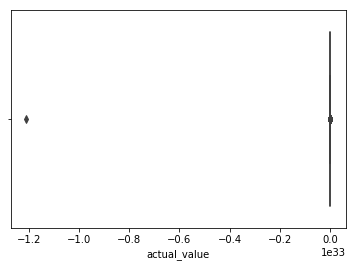

In [117]:


ax = sns.boxplot(dd.actual_value)

# from scipy import stats
# dd = dd[(np.abs(stats.zscore(dd)) < 3).all(axis=1)]

# dd_b = dd#[dd.actual_value > 0]

# ax = sns.distplot(dd_b['stored_value'] - dd_b['actual_value'])
np.median(dd_b['stored_value'] - dd_b['actual_value'])

/home/jarino/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


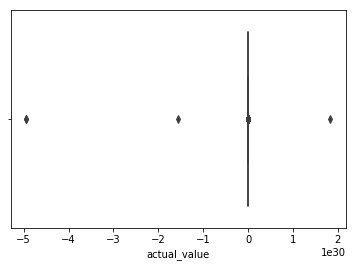

In [116]:
dd = pd.concat([x[0] for x in list(symreg.iterate_gem_data(single_mutation.__name__, MatchByActiveStrategy.__name__))])[['stored_value', 'actual_value']]

#dd = dd[dd.actual_value > 0]

ax = sns.boxplot(dd.actual_value)



#ax = sns.distplot(dd_b['stored_value'] - dd_b['actual_value'])
#ax.set_xlim(-0.5e27, 0.5e27)
#np.median(dd_b['stored_value'] - dd_b['actual_value'])

0.028941804974480845

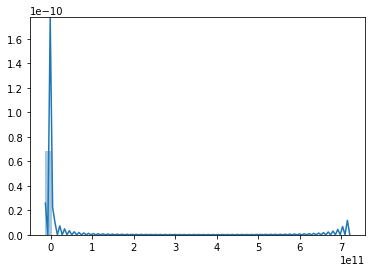

In [77]:
dd = pd.concat([x[0] for x in list(symreg.iterate_gem_data(probabilistic_mutation.__name__, MatchByActiveStrategy.__name__))])[['stored_value', 'actual_value']]

from scipy import stats
dd = dd[(np.abs(stats.zscore(dd)) < 3).all(axis=1)]

dd_b = dd#[dd.actual_value > 0]

ax = sns.distplot(dd_b['stored_value'] - dd_b['actual_value'])
np.median(dd_b['stored_value'] - dd_b['actual_value'])